<a href="https://colab.research.google.com/github/szucshey/osm-data-exploration/blob/main/climate/climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install folium osm2geojson geopandas regionmask --quiet

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 5.0 MB/s 
     |████████████████████████████████| 16.7 MB 54.9 MB/s 
     |████████████████████████████████| 6.3 MB 45.5 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [3]:
import folium
import requests
import json
import osm2geojson
import geopandas as gpd
import matplotlib.pyplot as plt


In [4]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
    [out:json];
    rel["ISO3166-1"~"^HU"]
    [admin_level=2]
    [type=boundary]
    [boundary=administrative];
    out geom;
    """

response = requests.get(overpass_url, params={'data': overpass_query})

#Az API válasz lementése egy json fileba
output = open("geojson.json", "w")
json.dump(response.json(), output)
output.close()

In [5]:
data = json.load(open("geojson.json", "r"))
geojson = osm2geojson.json2geojson(data)

#m = folium.Map(location=[47.161, 19.505], zoom_start=8, min_zoom=7, maxBounds=[[40.000, 10.000], [60.000, 30.000]], tiles=None, attr="", prefer_canvas=True, overlay=True)
#m.add_child(folium.GeoJson(geojson, name='geojson'))

#m

In [6]:
gdf = gpd.GeoDataFrame.from_features(geojson)

In [8]:
import xarray as xr
import regionmask
import numpy as np

#lon = np.arange(15, 24)
#lat = np.arange(45, 50)

#mask = regionmask.mask_geopandas(gdf, lon, lat)
ds = xr.open_dataarray("rr_ens_mean_0.1deg_reg_1950-1964_v25.0e.nc")
mask = regionmask.Regions(gdf['geometry'])
mask = mask.mask(ds, lat_name = 'latitude', lon_name = 'longitude')
#mask1
mask.to_netcdf("teszt.nc")

masked_nc = xr.open_dataarray("teszt.nc")


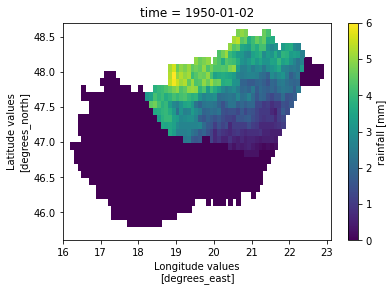

In [11]:
#ds = xr.open_dataarray("rr_ens_mean_0.1deg_reg_1950-1964_v25.0e.nc")
shape = mask1.where(masked_nc == 0)

shape[1, :, :].plot()
#ds.isel(time = 160).plot(xlim=[-25,43], ylim=[30,72])
#ds[5478, :, :].plot()

In [13]:
mask = ds.mask(ds, lat_name = 'latitude', lon_name = 'longitude')
mask

AttributeError: ignored

In [9]:
ds

<xarray.DataArray 'rr' (time: 5479, latitude: 465, longitude: 705)>
[1796153175 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude   (latitude) float64 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1964-12-31
Attributes:
    units:          mm
    long_name:      rainfall
    standard_name:  thickness_of_rainfall_amount
    cell_methods:   time: mean

In [10]:
mask1 = ds.sel(longitude=slice(15.96, 23.12), latitude=slice(45.55, 48.73))

In [27]:
mask1.mask(mask1.isel(time = 0), lat_name = 'latitude', lon_name = 'longitude').plot()

AttributeError: ignored

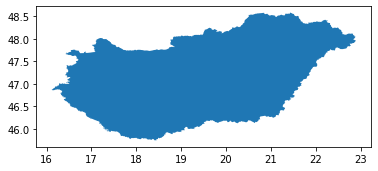

In [15]:
gdf['geometry'].plot()

In [1]:
shape[1, :, :].plot()

NameError: ignored